In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import scipy
from scipy.spatial import HalfspaceIntersection
from scipy.spatial import ConvexHull

from scipy.stats import truncnorm

import arviz

from DikinSamplers import RandomWalk, LangevinSampler

ImportError: dlopen(/Users/jameschok/miniforge3/lib/python3.10/site-packages/numpy/core/_multiarray_umath.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/libgfortran.5.dylib
  Referenced from: <D37BED4E-7F75-3467-A281-7E7E316989C9> /Users/jameschok/miniforge3/lib/libopenblas.0.dylib
  Reason: tried: '/Users/jameschok/miniforge3/lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/lib/python3.10/site-packages/numpy/core/../../../../libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/lib/python3.10/site-packages/numpy/core/../../../../libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/bin/../lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/bin/../lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/usr/local/lib/libgfortran.5.dylib' (no such file), '/usr/lib/libgfortran.5.dylib' (no such file, not in dyld cache)

ImportError: dlopen(/Users/jameschok/miniforge3/lib/python3.10/site-packages/numpy/core/_multiarray_umath.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/libgfortran.5.dylib
  Referenced from: <D37BED4E-7F75-3467-A281-7E7E316989C9> /Users/jameschok/miniforge3/lib/libopenblas.0.dylib
  Reason: tried: '/Users/jameschok/miniforge3/lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/lib/python3.10/site-packages/numpy/core/../../../../libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/lib/python3.10/site-packages/numpy/core/../../../../libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/bin/../lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/jameschok/miniforge3/bin/../lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/usr/local/lib/libgfortran.5.dylib' (no such file), '/usr/lib/libgfortran.5.dylib' (no such file, not in dyld cache)

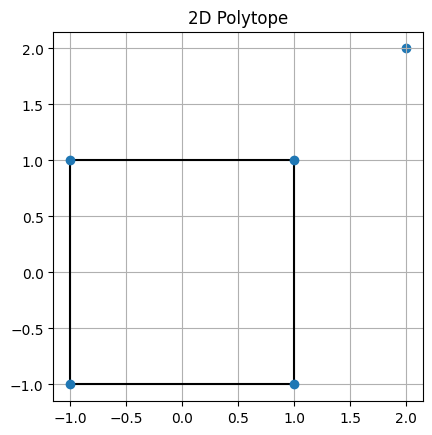

In [59]:
# Example A: n x 2 matrix
A = np.array([
    [1, 0],
    [-1, 0],
    [0, 1],
    [0, -1]
])

b = np.ones(len(A))  # a_i x <= 1

halfspaces = np.hstack((A, -b[:, None]))

# Feasible interior point (must strictly satisfy all constraints)
interior_point = np.array([0.0, 0.0])  # Make sure this is inside the polytope

hs = HalfspaceIntersection(halfspaces, interior_point)

# Plot
fig, ax = plt.subplots()
for simplex in ConvexHull(hs.intersections).simplices:
    points = hs.intersections[simplex]
    ax.plot(points[:, 0], points[:, 1], 'k-')
ax.plot(*zip(*hs.intersections), 'o')  # Vertices
ax.set_aspect('equal')
plt.grid(True)
plt.title("2D Polytope")
plt.scatter(2, 2)
plt.show()

In [60]:
mean, var, skew, kurt = truncnorm.stats(-1, 1, moments='mvsk')
var

np.float64(0.291125094772793)

In [100]:
dim = 10
A = np.concatenate([np.eye(dim), -np.eye(dim)], axis=0)
A[abs(A) < 1e-5] = 0

b = np.ones(len(A))  # a_i x <= 1

approx_var = 2 * scipy.special.gamma((dim + 2) / 2) / scipy.special.gamma(dim / 2)

In [114]:
num_iters = 20_000

log_pdf = lambda x: -0.5 * torch.linalg.norm(x, axis=-1) ** 2

h = 1
sampler = RandomWalk(h, torch.tensor(A, dtype=torch.float64), log_pdf, e=1e-3, include_lazification=False)
history1 = sampler.run(num_iters)

sampler = LangevinSampler(h, torch.tensor(A, dtype=torch.float64), log_pdf, e=1e-3, include_lazification=False)
history2 = sampler.run(num_iters)

In [115]:
arviz.ess(history1[:, 0]), arviz.ess(history1[:, 1])

(np.float64(32.837615683029746), np.float64(14.0140736331321))

In [116]:
arviz.ess(history2[:, 0]), arviz.ess(history2[:, 1])

(np.float64(28.797042849383185), np.float64(66.16559295760221))

In [117]:
(history2 ** 2).mean(axis=0)

array([0.29927355, 0.28103635, 0.32269397, 0.41791523, 0.27160645,
       0.33519134, 0.35567325, 0.2689797 , 0.34021324, 0.26882902],
      dtype=float32)

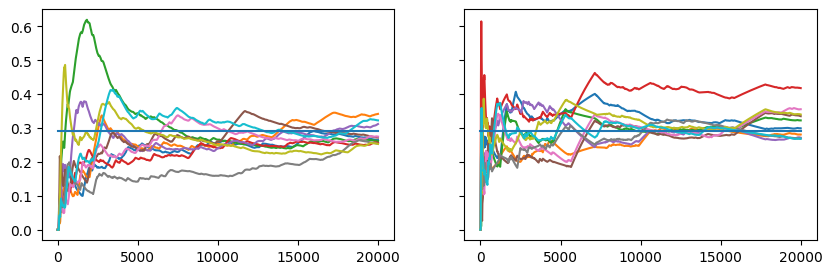

In [118]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

for i, history in enumerate([history1, history2]):
    axs[i].plot((history ** 2).cumsum(axis=0) / np.arange(1, num_iters + 1)[:, None]);
    axs[i].plot([0, num_iters - 1], [var, var])

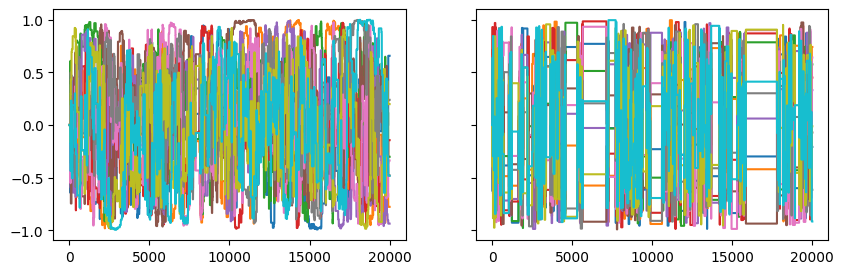

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

for i, history in enumerate([history1, history2]):
    axs[i].plot(history)

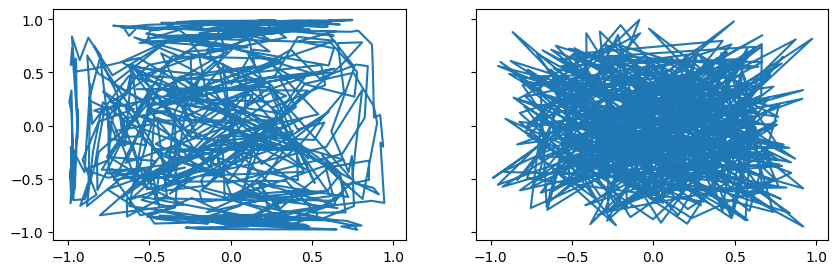

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True, sharex=True)

for i, history in enumerate([history1, history2]):
    axs[i].plot(history[:, 0], history[:, 1])

In [111]:
log_density = lambda x: -0.5 * torch.linalg.norm(x, axis=-1) ** 2

def log_proposal(y, x, A, e, h):
    with torch.no_grad():
        H = (A[:, :, None] * A[:, None, :]) / ((1 - A @ x) ** 2)[:, None, None]
        Sigma_inv = (H.sum(axis=0) + e * torch.eye(len(x), dtype=torch.float64))

        eig_vals, eig_vecs = torch.linalg.eigh(Sigma_inv)
        Sigma = eig_vecs @ torch.diag(1 / eig_vals) @ eig_vecs.T
        log_det_sigma = (1 / eig_vals).sum()
        
        out = -0.5 * (y - x) @ Sigma_inv @ (y - x) - 0.5 * log_det_sigma
    return out

def acceptance_ratio(y, x, A, e, h):
    with torch.no_grad():
        temp = A @ y
    
    if (temp > 1).any():
        return 0
    
    log_numerator = log_density(y) + log_proposal(x, y, A, e, h)
    log_denominator = log_density(x) + log_proposal(y, x, A, e, h)
        
    return torch.exp(log_numerator - log_denominator)

In [112]:
A_torch = torch.tensor(A, dtype=torch.float64)
particle = torch.zeros(dim, dtype=torch.float64, requires_grad=True)
h = 1

num_iters = 10_000
history = torch.zeros(num_iters, dim)
for i in range(num_iters):
    val = log_density(particle)
    val.backward()
    
    with torch.no_grad():
        H = (A_torch[:, :, None] * A_torch[:, None, :]) / ((1 - A_torch @ particle) ** 2)[:, None, None]
        H = H.sum(axis=0)
        
        eig_vals, eig_vecs = torch.linalg.eigh(H)
        G_inv = eig_vecs @ torch.diag(1 / eig_vals) @ eig_vecs.T
        sqrt_G_inv = eig_vecs @ torch.diag(1 / torch.sqrt(eig_vals)) @ eig_vecs.T
        
        temp_particle = particle + sqrt_G_inv @ torch.randn_like(particle)
        
    a_temp = acceptance_ratio(temp_particle, particle, A_torch, 0, h)
    if torch.rand(1) < a_temp:
        with torch.no_grad():
            particle[:] = temp_particle
        
    history[i] = particle.detach().clone()
    
    particle.grad.zero_()
    
history = history.detach().clone().numpy()

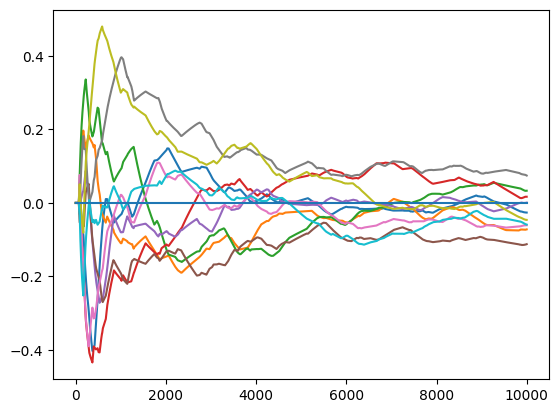

In [113]:
plt.plot(history.cumsum(axis=0) / np.arange(1, num_iters + 1)[:, None]);
plt.plot([0, num_iters - 1], [0, 0])

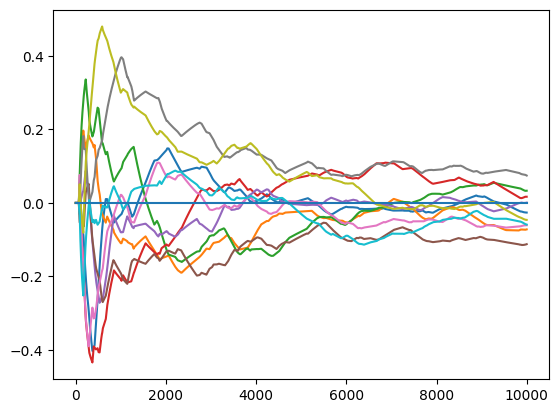

In [115]:
plt.plot(history.cumsum(axis=0) / np.arange(1, num_iters + 1)[:, None]);
plt.plot([0, num_iters - 1], [0, 0])

In [116]:
arviz.ess(history[:, 0]), arviz.ess(history[:, 1])

(np.float64(51.0970393722833), np.float64(29.614480266951283))